Кейс №1 - Приложение знакомств

Вы работаете аналитиком в приложении для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать одну или несколько метрик, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.

В поле ответа прикрепите файл формата .ipynb — то есть обычный Jupyter Notebook со всеми вашими действиями, результатами, графиками и выводами.

# 1 Выгрузка данных

Выгрузим и посмотрим на наши данные.

In [3]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency, normaltest, bartlett, ttest_ind
import pingouin as pg

In [4]:
# выгрузим данные в датафрейм
dating_df = pd.read_csv ('dating_data.csv')

In [5]:
dating_df

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


In [6]:
# проверим на пропущенные значения
dating_df.isnull().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [7]:
# посмотрим типы переменных
dating_df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [8]:
# посмотрим количество уникальных юзеров
dating_df.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

# 2 Исследование количества мэтчей в группах методом хи-квадрата

Новый алгоритм приложения предполагает, что теперь пользователи будут чаще находить пару - мэтч. 

Метрика:\
В данном случае в качестве метрики, которую нужно посчитать и соотнести, будет количество мэтчей в группах.

Для проверки построим таблицу сопряжённости по группам и мэтчам/не_мэтчам.

Наша нулевая гипотеза - процент мэтчей и не_мэтчей в группах статистически не различается.

Проверим гипотезу с помощью критерия хи-квадрат (критерия согласия Пирсона).

In [13]:
# создадим кросс-таблицу 2х2, в которой будут категории мэтч/не мэтч и группы пользователей
df_exp_1 = pd.crosstab (dating_df.is_match, dating_df.group)
df_exp_1

group,0,1
is_match,,
0,3858,5813
1,934,3909


In [12]:
# с помощью функции из библиотеки scipy.stats посчитаем критерий хи-квадрат.
chi2_contingency (df_exp_1)

(618.6889141576197,
 1.441829916366341e-136,
 1,
 array([[3193.01584677, 6477.98415323],
        [1598.98415323, 3244.01584677]]))

## Вывод по п. 2
Наше p-value =  1.4418299163662586e-136, число гораздо меньше порогового значения p-значимости - 0,05. Это означает, что мы отклоняем нулевую гипотезу, и значения в группах статистически значимо различаются.

# 3 Исследование различий по средним значениям мэтчей в группах

В нашей выборке есть 2000 тысячи уникальных юзеров всего, которые образовывают в совокупности 14514 событий, тоесть пользователи прокрутили большое количество предложенных вариантов, и какие-то из них дали мэтч. В данном случае мы можем проверить, различаются ли распределения значений по мэтчам на каждого пользователя в первой и второй группах, и как различаются средние.

Метрика:\
Метрикой в данном случае является среднее количество мэтчей на одного пользователя.

Для начала сгруппируем наши данные по пользователям и их мэтчам.

In [82]:
dating_df.groupby(['user_id_1', 'group'], as_index = False).agg({'is_match':'count'}) ['is_match'] +\
dating_df.groupby(['user_id_2', 'group'], as_index = False).agg({'is_match':'count'}) ['is_match']

0      37
1      39
2      25
3      17
4      34
       ..
995    14
996    26
997    36
998    20
999    38
Name: is_match, Length: 1000, dtype: int64

In [105]:
# в отдельный датасет сохраним данные по юзерам из первого столбца, просуммировав мэтчи
df_exp_2 = dating_df.groupby(['user_id_1', 'group'], as_index = False).agg({'is_match':'sum'})

In [106]:
# теперь в этом столбце посчитаем среднее количество мэтчей из всех прокруток приложения на каждого пользователя
# для этого соберём все мэчти по пользователям и поделим их на количество всех прокруток для каждого пользователя
df_exp_2 ['is_match'] = ((df_exp_2.is_match + dating_df.groupby(['user_id_2', 'group'], as_index = False)\
                                                        .agg({'is_match':'sum'})['is_match'])/\
                        (dating_df.groupby(['user_id_1', 'group'], as_index = False).agg({'is_match':'count'}) ['is_match'] +\
                        dating_df.groupby(['user_id_2', 'group'], as_index = False).agg({'is_match':'count'}) ['is_match']))\
                        .round(3) #округлим до третьего знака

Забежав чуть вперёд, мы уже знаем, что имеем в датасете значения с бесконечностью после запятой, и с ними не справляются функции scipy. Определим такие значения и попробуем их исправить.

In [107]:
# заменим все значения inf на NaN, а потом удалим эти строки
df_exp_2 = df_exp_2.replace(np.inf, np.nan).dropna()
df_exp_2.isna().sum()

user_id_1    0
group        0
is_match     0
dtype: int64

Проверим, распределены ли наши данные нормально

In [99]:
# функцией библиотеки scipy проверяем контрольную группу 0
normaltest (df_exp_2.query('group == 0').is_match)

NormaltestResult(statistic=3.127206383895322, pvalue=0.20938027306169532)

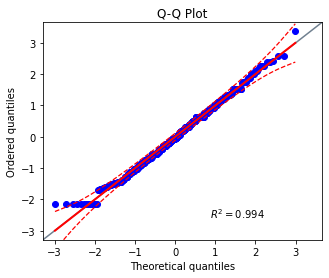

In [100]:
# построим визуализацию
pg.qqplot(df_exp_2.query('group == 0').is_match, dist='norm', confidence=0.95)

In [108]:
# функцией библиотеки scipy проверяем тестовую группу 1
normaltest (df_exp_2.query('group == 1').is_match)

NormaltestResult(statistic=4.179015622095917, pvalue=0.1237480282432742)

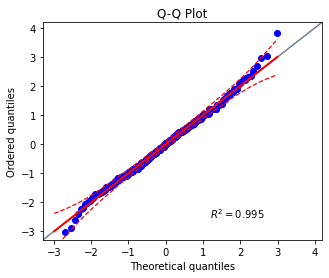

In [109]:
# строим визуализацию
pg.qqplot(df_exp_2.query('group == 1').is_match, dist='norm', confidence=0.95)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


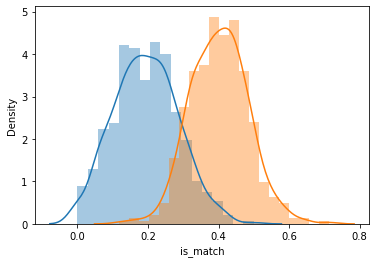

In [110]:
# также построим графики распределения величин в двух группах
sns.distplot (df_exp_2.query('group == 0').is_match)
sns.distplot (df_exp_2.query('group == 1').is_match)

Распределения в обеих группах близки к нормальным. Для решения о проведения t-теста нам нужно убедится в гомогенности дисперсий.\
Мы воспользуемся критерием Бартлетта, так как он хорошо подходит для нормальных выборок.

In [116]:
# используем функцию из библиотеки scipy.stats
bartlett (df_exp_2.query('group == 0').is_match, df_exp_2.query('group == 1').is_match)

BartlettResult(statistic=5.5157699993488265, pvalue=0.018845775479613486)

P-значение выше 0.05, следовательно, нулевая гипотеза, что дисперсии гомогенны, не опровергается.

### Проведение T-тестирования

In [119]:
# воспользуемся функцией из библиотеки scipy.stats для проведения t-теста
ttest_ind (df_exp_2.query('group == 0').is_match, df_exp_2.query('group == 1').is_match)

Ttest_indResult(statistic=-38.228084504361895, pvalue=1.1444059794687075e-197)

P-значение ниже 0.05. Нулевая гипотеза отвергнута и средние значения в выборках статистически значимо различаются.

In [120]:
# среднее значение в контрольной группе 0
df_exp_2.query('group == 0').is_match.mean()

0.1935449101796407

In [122]:
# среднее значение в тестовой группе 1
df_exp_2.query('group == 1').is_match.mean()

0.4022685370741483

## Вывод по п.3
95%-ные доверительные интервалы медиан контрольной и тестовой групп не пересекаются, а следовательно статистически значимо различаются.

# Вывод по проведённому анализу данных

На основании двух экспериментов, в которых зафиксированы статистически значимые различия между двумя группами в пользу тестовой группы 1, делаем вывод: в тестовой группе 1 количество мэтчей на одного пользователя статистически значимо выше контрольной группы 0, и в тестовой группе 1 пользователи статистически значимо чаще находят себе мэтчи. 

Исходя из сказанного выше мы можем предложить бизнесу полностью перейти на обновлённую версию приложения, сказав, что увеличенная частоста мэтчей возможно увеличит интерес пользователей к приложению. Но в данном случае также стоит подумать на счёт того, не возымеет ли это обратного эффекта. К примеру, пользователей может отпугнуть такая частота мэтчей, будет повод задуматься о ботах в приложении. Либо слишком быстро найдя пару, пользователи также быстро покинут приложение.